# UCI HAR
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [ ]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI_HAR_Dataset/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [ ]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시작)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train[:5])

y_train shape: (7352,)
y_test shape: (2947,)
[4 4 4 4 4]


## Model 1
- CNN 3, GRU 1

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GRU(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,510 (1.12 MB)

 Trainable params: 292,614 (1.12 MB)

 Non-trainable params: 896 (3.50 KB)

None


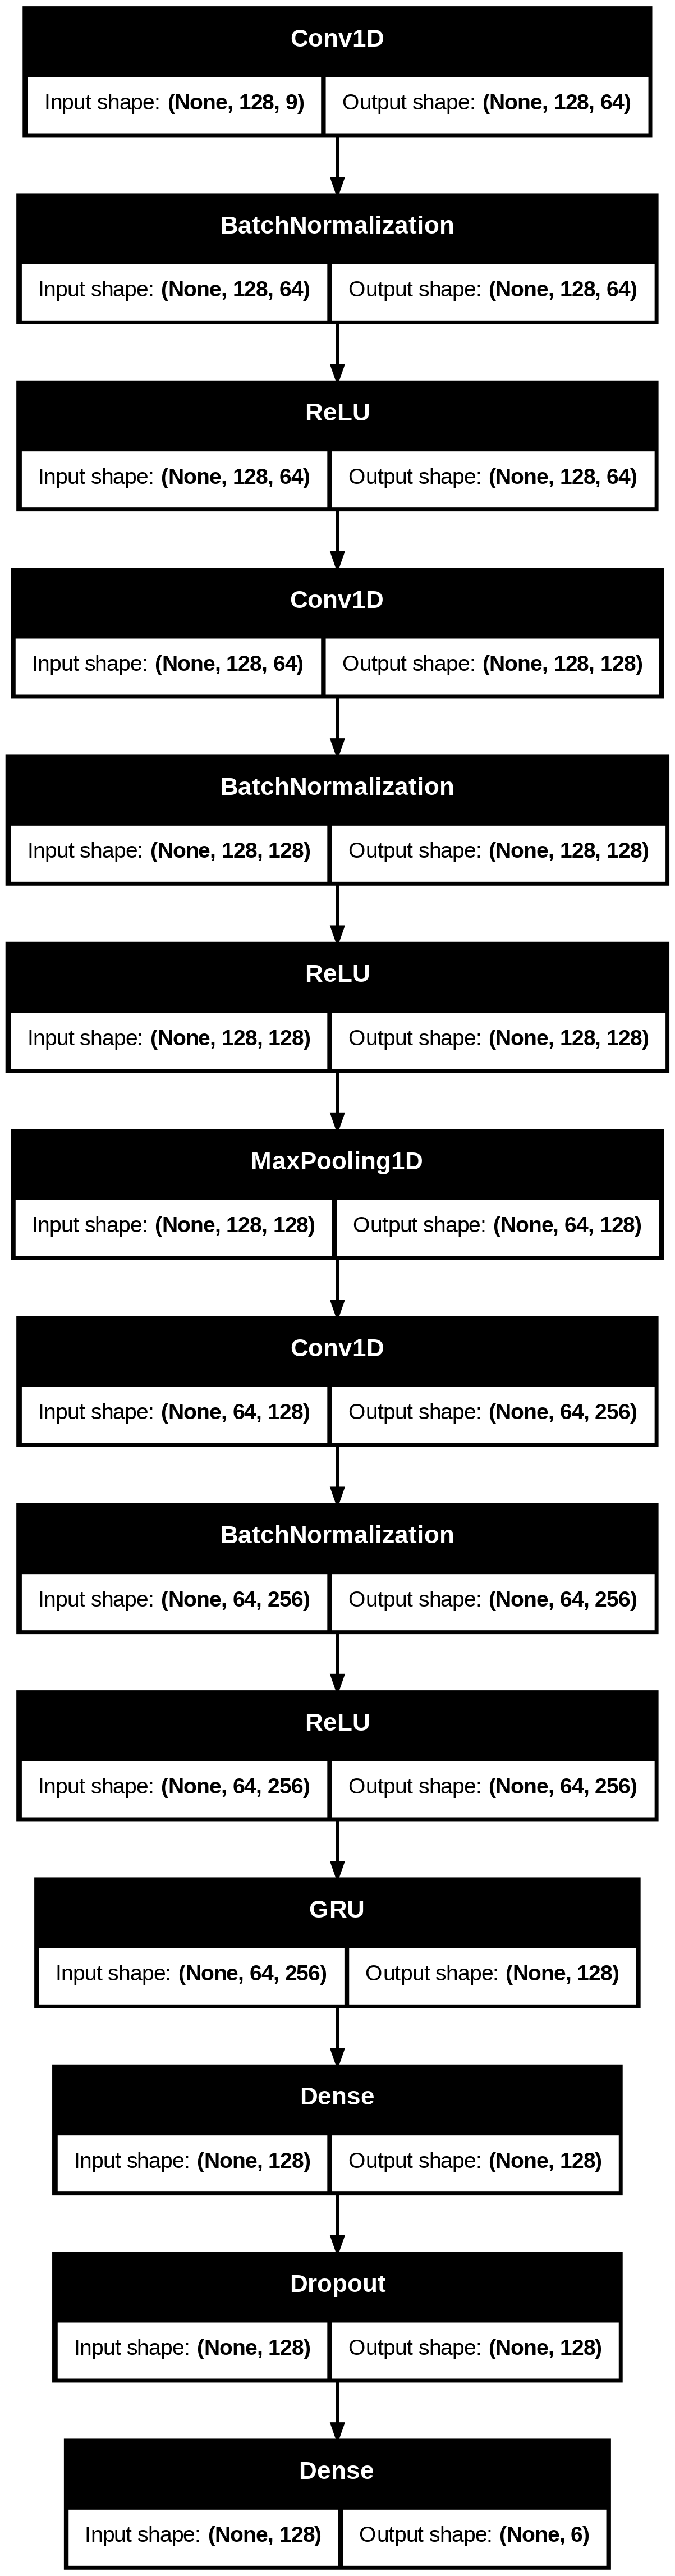

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_best.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7654 - sparse_categorical_accuracy: 0.6748
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.80922, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.7621 - sparse_categorical_accuracy: 0.6763 - val_loss: 3.6171 - val_sparse_categorical_accuracy: 0.2740
Epoch 2/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9455
Epoch 2: sparse_categorical_accuracy improved from 0.80922 to 0.94814, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9456 - val_loss: 2.3213 - val_sparse_categorical_accuracy: 0.4276
Epoch 3/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.9581
Epoch 3: sparse_categorical_accuracy improved from 0.94814 to 0.95477, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.4352 - val_sparse_categorical_accuracy: 0.8620
Epoch 4/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1104 - sparse_categorical_accuracy: 0.9498
Epoch 4: sparse_categorical_accuracy did not improve from 0.95477
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1101 - sparse_categorical_accuracy: 0.9498 - val_loss: 0.2432 - val_sparse_categorical_accuracy: 0.9198
Epoch 5/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9554
Epoch 5: sparse_categorical_accuracy did not improve from 0.95477
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0950 - sparse_categorical_accuracy: 0.9554 - val_loss: 0.2858 - val_sparse_categorical_accuracy: 0.9320
Epoch 6/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1003 - sparse_categorical_accuracy: 0.9586
Epoch 6: sparse_categorical_accuracy did not improve from 0.95477
92/92 ━━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.2795 - val_sparse_categorical_accuracy: 0.9041
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9603
Epoch 8: sparse_categorical_accuracy did not improve from 0.95919
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9603 - val_loss: 0.3781 - val_sparse_categorical_accuracy: 0.9375
Epoch 9/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9577
Epoch 9: sparse_categorical_accuracy improved from 0.95919 to 0.95987, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9577 - val_loss: 0.2971 - val_sparse_categorical_accuracy: 0.9300
Epoch 10/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0908 - sparse_categorical_accuracy: 0.9563
Epoch 10: sparse_categorical_accuracy did not improve from 0.95987
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0908 - sparse_categorical_accuracy: 0.9564 - val_loss: 0.3645 - val_sparse_categorical_accuracy: 0.9361
Epoch 11/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1191 - sparse_categorical_accuracy: 0.9502
Epoch 11: sparse_categorical_accuracy did not improve from 0.95987
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1183 - sparse_categorical_accuracy: 0.9504 - val_loss: 0.3025 - val_sparse_categorical_accuracy: 0.9191
Epoch 12/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9626
Epoch 12: sparse_categorical_accuracy improved from 0.95987 to 0.96242, saving model t

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9626 - val_loss: 0.2945 - val_sparse_categorical_accuracy: 0.9286
Epoch 13/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9590
Epoch 13: sparse_categorical_accuracy did not improve from 0.96242
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.3133 - val_sparse_categorical_accuracy: 0.9354
Epoch 14/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0809 - sparse_categorical_accuracy: 0.9601
Epoch 14: sparse_categorical_accuracy improved from 0.96242 to 0.96395, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0809 - sparse_categorical_accuracy: 0.9603 - val_loss: 0.3571 - val_sparse_categorical_accuracy: 0.9279
Epoch 15/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9588
Epoch 15: sparse_categorical_accuracy did not improve from 0.96395
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0933 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.3197 - val_sparse_categorical_accuracy: 0.9273
Epoch 16/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0811 - sparse_categorical_accuracy: 0.9607
Epoch 16: sparse_categorical_accuracy did not improve from 0.96395
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0812 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.3560 - val_sparse_categorical_accuracy: 0.9041
Epoch 17/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9616
Epoch 17: sparse_categorical_accuracy did not improve from 0.96395
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0734 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.3231 - val_sparse_categorical_accuracy: 0.9232
Epoch 25/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9624
Epoch 25: sparse_categorical_accuracy did not improve from 0.96514
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0746 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.3286 - val_sparse_categorical_accuracy: 0.9286
Epoch 26/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.9649
Epoch 26: sparse_categorical_accuracy improved from 0.96514 to 0.96718, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.3480 - val_sparse_categorical_accuracy: 0.9198
Epoch 27/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0788 - sparse_categorical_accuracy: 0.9646
Epoch 27: sparse_categorical_accuracy did not improve from 0.96718
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0789 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.3254 - val_sparse_categorical_accuracy: 0.9279
Epoch 28/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0787 - sparse_categorical_accuracy: 0.9625
Epoch 28: sparse_categorical_accuracy did not improve from 0.96718
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9626 - val_loss: 0.2883 - val_sparse_categorical_accuracy: 0.9286
Epoch 29/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0724 - sparse_categorical_accuracy: 0.9638
Epoch 29: sparse_categorical_accuracy did not improve from 0.96718
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0718 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.3409 - val_sparse_categorical_accuracy: 0.9096
Epoch 31/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9633
Epoch 31: sparse_categorical_accuracy did not improve from 0.96820
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.3771 - val_sparse_categorical_accuracy: 0.9171
Epoch 32/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9642
Epoch 32: sparse_categorical_accuracy improved from 0.96820 to 0.96837, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0701 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.3199 - val_sparse_categorical_accuracy: 0.9293
Epoch 33/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0757 - sparse_categorical_accuracy: 0.9679
Epoch 33: sparse_categorical_accuracy improved from 0.96837 to 0.96888, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.3416 - val_sparse_categorical_accuracy: 0.9273
Epoch 34/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9725
Epoch 34: sparse_categorical_accuracy improved from 0.96888 to 0.97075, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.3037 - val_sparse_categorical_accuracy: 0.9395
Epoch 35/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9621
Epoch 35: sparse_categorical_accuracy did not improve from 0.97075
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9622 - val_loss: 0.3142 - val_sparse_categorical_accuracy: 0.9109
Epoch 36/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0643 - sparse_categorical_accuracy: 0.9713
Epoch 36: sparse_categorical_accuracy did not improve from 0.97075
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0645 - sparse_categorical_accuracy: 0.9711 - val_loss: 0.3361 - val_sparse_categorical_accuracy: 0.9007
Epoch 37/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9688
Epoch 37: sparse_categorical_accuracy did not improve from 0.97075
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0518 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.2997 - val_sparse_categorical_accuracy: 0.9375
Epoch 42/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9726
Epoch 42: sparse_categorical_accuracy did not improve from 0.97415
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0566 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.3218 - val_sparse_categorical_accuracy: 0.9415
Epoch 43/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9697
Epoch 43: sparse_categorical_accuracy did not improve from 0.97415
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.3246 - val_sparse_categorical_accuracy: 0.9477
Epoch 44/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9703
Epoch 44: sparse_categorical_accuracy did not improve from 0.97415
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0540 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.3287 - val_sparse_categorical_accuracy: 0.9327
Epoch 48/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0550 - sparse_categorical_accuracy: 0.9719
Epoch 48: sparse_categorical_accuracy did not improve from 0.97517
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0551 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.3604 - val_sparse_categorical_accuracy: 0.9463
Epoch 49/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9706
Epoch 49: sparse_categorical_accuracy did not improve from 0.97517
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.3631 - val_sparse_categorical_accuracy: 0.9320
Epoch 50/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0487 - sparse_categorical_accuracy: 0.9783
Epoch 50: sparse_categorical_accuracy improved from 0.97517 to 0.97824, saving model t

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0487 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.3628 - val_sparse_categorical_accuracy: 0.9279
Epoch 51/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0612 - sparse_categorical_accuracy: 0.9707
Epoch 51: sparse_categorical_accuracy did not improve from 0.97824
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0612 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.3024 - val_sparse_categorical_accuracy: 0.9239
Epoch 52/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9753
Epoch 52: sparse_categorical_accuracy did not improve from 0.97824
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0564 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.4209 - val_sparse_categorical_accuracy: 0.9245
Epoch 53/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0545 - sparse_categorical_accuracy: 0.9767
Epoch 53: sparse_categorical_accuracy did not improve from 0.97824
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9779 - val_loss: 0.4561 - val_sparse_categorical_accuracy: 0.9177
Epoch 63/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0452 - sparse_categorical_accuracy: 0.9797
Epoch 63: sparse_categorical_accuracy did not improve from 0.97858
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.4207 - val_sparse_categorical_accuracy: 0.9368
Epoch 64/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9796
Epoch 64: sparse_categorical_accuracy improved from 0.97858 to 0.97926, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.4323 - val_sparse_categorical_accuracy: 0.9225
Epoch 65/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0449 - sparse_categorical_accuracy: 0.9769
Epoch 65: sparse_categorical_accuracy improved from 0.97926 to 0.98011, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9770 - val_loss: 0.4733 - val_sparse_categorical_accuracy: 0.9150
Epoch 66/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9797
Epoch 66: sparse_categorical_accuracy did not improve from 0.98011
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.3648 - val_sparse_categorical_accuracy: 0.9164
Epoch 67/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0548 - sparse_categorical_accuracy: 0.9797
Epoch 67: sparse_categorical_accuracy did not improve from 0.98011
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.4380 - val_sparse_categorical_accuracy: 0.9320
Epoch 68/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0453 - sparse_categorical_accuracy: 0.9790
Epoch 68: sparse_categorical_accuracy did not improve from 0.98011
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0409 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.4521 - val_sparse_categorical_accuracy: 0.9252
Epoch 71/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9829
Epoch 71: sparse_categorical_accuracy improved from 0.98113 to 0.98215, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0401 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.4421 - val_sparse_categorical_accuracy: 0.9320
Epoch 72/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9819
Epoch 72: sparse_categorical_accuracy did not improve from 0.98215
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.4167 - val_sparse_categorical_accuracy: 0.9361
Epoch 73/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0450 - sparse_categorical_accuracy: 0.9824
Epoch 73: sparse_categorical_accuracy did not improve from 0.98215
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0450 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.4300 - val_sparse_categorical_accuracy: 0.9143
Epoch 74/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0401 - sparse_categorical_accuracy: 0.9788
Epoch 74: sparse_categorical_accuracy did not improve from 0.98215
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.3680 - val_sparse_categorical_accuracy: 0.9184
Epoch 78/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9845
Epoch 78: sparse_categorical_accuracy did not improve from 0.98266
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.4252 - val_sparse_categorical_accuracy: 0.9456
Epoch 79/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9857
Epoch 79: sparse_categorical_accuracy did not improve from 0.98266
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.4253 - val_sparse_categorical_accuracy: 0.9300
Epoch 80/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9804
Epoch 80: sparse_categorical_accuracy did not improve from 0.98266
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.4183 - val_sparse_categorical_accuracy: 0.9402
Epoch 83/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0374 - sparse_categorical_accuracy: 0.9840
Epoch 83: sparse_categorical_accuracy improved from 0.98402 to 0.98419, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.3622 - val_sparse_categorical_accuracy: 0.9191
Epoch 84/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9861
Epoch 84: sparse_categorical_accuracy did not improve from 0.98419
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0350 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.4015 - val_sparse_categorical_accuracy: 0.9320
Epoch 85/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9846
Epoch 85: sparse_categorical_accuracy did not improve from 0.98419
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0357 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.2908 - val_sparse_categorical_accuracy: 0.9497
Epoch 86/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0377 - sparse_categorical_accuracy: 0.9838
Epoch 86: sparse_categorical_accuracy did not improve from 0.98419
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.5559 - val_sparse_categorical_accuracy: 0.9089
Epoch 92/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9831
Epoch 92: sparse_categorical_accuracy improved from 0.98640 to 0.98776, saving model to UCI_HAR_CNN_GRU_best.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.4558 - val_sparse_categorical_accuracy: 0.9470
Epoch 93/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0306 - sparse_categorical_accuracy: 0.9882
Epoch 93: sparse_categorical_accuracy did not improve from 0.98776
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0307 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.4074 - val_sparse_categorical_accuracy: 0.9388
Epoch 94/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9851
Epoch 94: sparse_categorical_accuracy did not improve from 0.98776
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.4074 - val_sparse_categorical_accuracy: 0.9320
Epoch 95/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9882
Epoch 95: sparse_categorical_accuracy did not improve from 0.98776
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.4774 - val_sparse_categorical_accuracy: 0.9354
Epoch 97/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9866
Epoch 97: sparse_categorical_accuracy did not improve from 0.98946
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0294 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.4750 - val_sparse_categorical_accuracy: 0.9490
Epoch 98/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0277 - sparse_categorical_accuracy: 0.9868
Epoch 98: sparse_categorical_accuracy did not improve from 0.98946
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.5677 - val_sparse_categorical_accuracy: 0.9300
Epoch 99/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0286 - sparse_categorical_accuracy: 0.9906
Epoch 99: sparse_categorical_accuracy improved from 0.98946 to 0.99014, saving model t

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0287 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.5541 - val_sparse_categorical_accuracy: 0.9198
Epoch 100/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9871
Epoch 100: sparse_categorical_accuracy did not improve from 0.99014
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.4332 - val_sparse_categorical_accuracy: 0.9422
Restoring model weights from the end of the best epoch: 99.


In [ ]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_CNN_GRU_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 97.25%
Training loss: 0.1457
Test accuracy: 92.43%
Test loss: 0.5374


model.predict
- 각 시퀀스 샘플마다, 모든 클래스에 대한 예측 확률 벡터
- y_pred_proba.shape -> (샘플 수, 클래스 수)

np.argmax
- 최대 값의 인덱스를 선택 = 라벨

In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9415    0.9699       496
           1     0.9801    0.9406    0.9599       471
           2     0.8870    0.9905    0.9359       420
           3     0.8531    0.8513    0.8522       491
           4     0.8440    0.8647    0.8542       532
           5     0.9924    0.9683    0.9802       537

    accuracy                         0.9243      2947
   macro avg     0.9261    0.9261    0.9254      2947
weighted avg     0.9267    0.9243    0.9248      2947



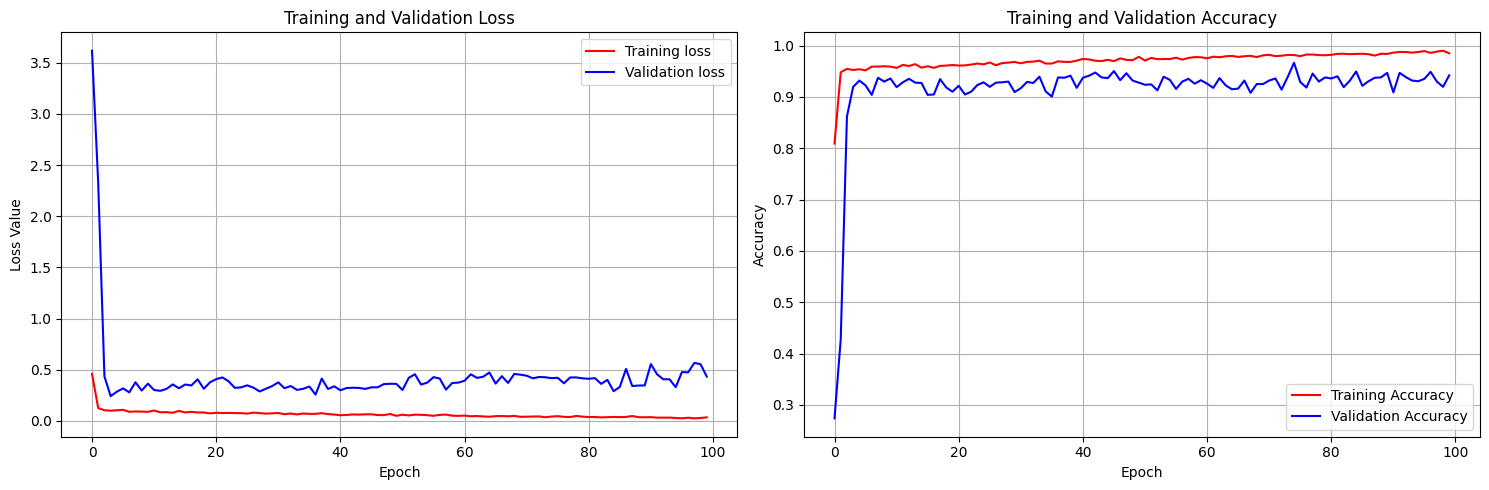

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

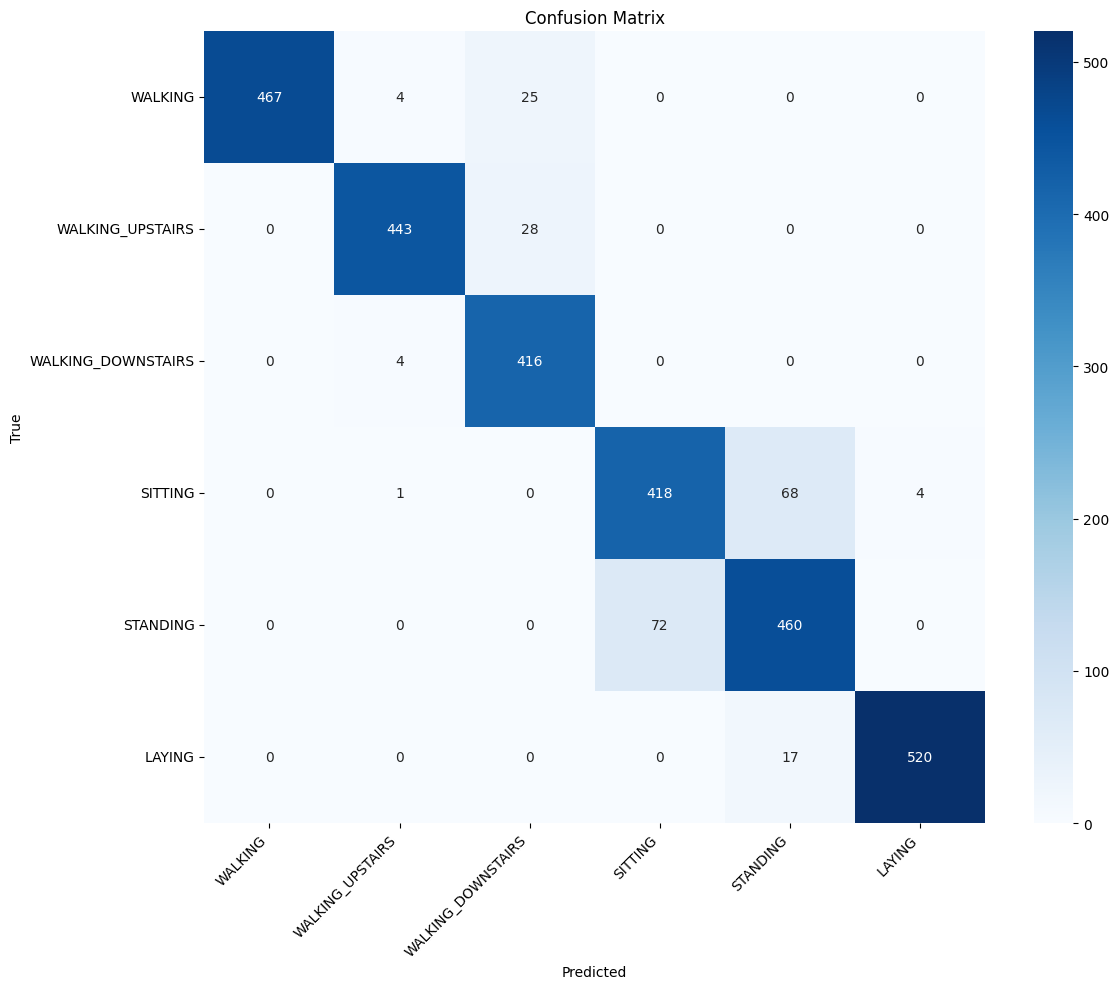

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 3, GRU 2

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GRU(128, return_sequences=True, dropout=0.2),
    GRU(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64, 128)        │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,582 (1.50 MB)

 Trainable params: 391,686 (1.49 MB)

 Non-trainable params: 896 (3.50 KB)

None


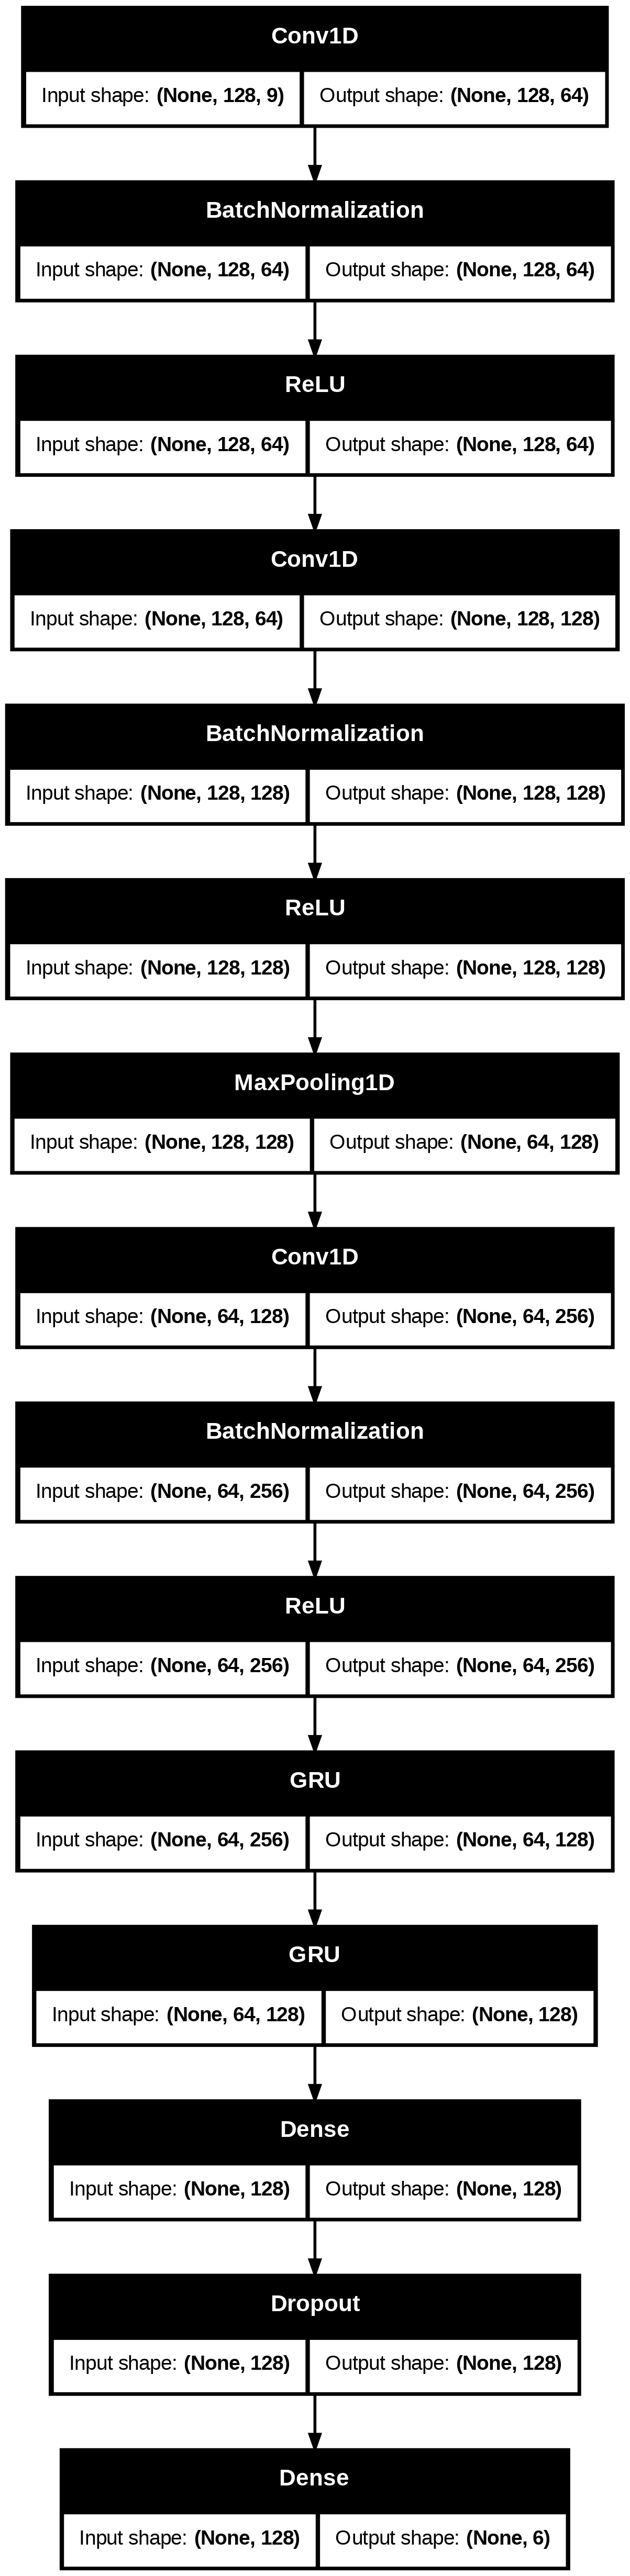

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_best2.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6975 - sparse_categorical_accuracy: 0.7141
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.83625, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.6915 - sparse_categorical_accuracy: 0.7168 - val_loss: 4.2623 - val_sparse_categorical_accuracy: 0.2848
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1609 - sparse_categorical_accuracy: 0.9408
Epoch 2: sparse_categorical_accuracy improved from 0.83625 to 0.94712, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9409 - val_loss: 2.7211 - val_sparse_categorical_accuracy: 0.3970
Epoch 3/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1321 - sparse_categorical_accuracy: 0.9465
Epoch 3: sparse_categorical_accuracy did not improve from 0.94712
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1327 - sparse_categorical_accuracy: 0.9463 - val_loss: 0.5167 - val_sparse_categorical_accuracy: 0.8355
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9476
Epoch 4: sparse_categorical_accuracy improved from 0.94712 to 0.94916, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9476 - val_loss: 0.2680 - val_sparse_categorical_accuracy: 0.9089
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1219 - sparse_categorical_accuracy: 0.9425
Epoch 5: sparse_categorical_accuracy improved from 0.94916 to 0.95035, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1218 - sparse_categorical_accuracy: 0.9426 - val_loss: 0.2330 - val_sparse_categorical_accuracy: 0.9205
Epoch 6/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.9511
Epoch 6: sparse_categorical_accuracy improved from 0.95035 to 0.95205, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.9511 - val_loss: 0.2722 - val_sparse_categorical_accuracy: 0.9164
Epoch 7/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9580
Epoch 7: sparse_categorical_accuracy improved from 0.95205 to 0.95664, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.2861 - val_sparse_categorical_accuracy: 0.9313
Epoch 8/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0988 - sparse_categorical_accuracy: 0.9611
Epoch 8: sparse_categorical_accuracy improved from 0.95664 to 0.95885, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0987 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.3193 - val_sparse_categorical_accuracy: 0.9089
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9544
Epoch 9: sparse_categorical_accuracy did not improve from 0.95885
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0932 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.3828 - val_sparse_categorical_accuracy: 0.9001
Epoch 10/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1118 - sparse_categorical_accuracy: 0.9515
Epoch 10: sparse_categorical_accuracy did not improve from 0.95885
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.3028 - val_sparse_categorical_accuracy: 0.9388
Epoch 11/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0972 - sparse_categorical_accuracy: 0.9591
Epoch 11: sparse_categorical_accuracy did not improve from 0.95885
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0916 - sparse_categorical_accuracy: 0.9566 - val_loss: 0.3694 - val_sparse_categorical_accuracy: 0.9293
Epoch 22/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9545
Epoch 22: sparse_categorical_accuracy did not improve from 0.95902
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9545 - val_loss: 0.3768 - val_sparse_categorical_accuracy: 0.9089
Epoch 23/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9582
Epoch 23: sparse_categorical_accuracy improved from 0.95902 to 0.96123, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0901 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.3325 - val_sparse_categorical_accuracy: 0.9245
Epoch 24/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0903 - sparse_categorical_accuracy: 0.9576
Epoch 24: sparse_categorical_accuracy did not improve from 0.96123
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0903 - sparse_categorical_accuracy: 0.9576 - val_loss: 0.3599 - val_sparse_categorical_accuracy: 0.9205
Epoch 25/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9609
Epoch 25: sparse_categorical_accuracy did not improve from 0.96123
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9609 - val_loss: 0.3599 - val_sparse_categorical_accuracy: 0.8899
Epoch 26/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0841 - sparse_categorical_accuracy: 0.9603
Epoch 26: sparse_categorical_accuracy did not improve from 0.96123
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.4016 - val_sparse_categorical_accuracy: 0.9198
Epoch 31/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0752 - sparse_categorical_accuracy: 0.9619
Epoch 31: sparse_categorical_accuracy did not improve from 0.96242
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0754 - sparse_categorical_accuracy: 0.9618 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 0.9143
Epoch 32/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0802 - sparse_categorical_accuracy: 0.9586
Epoch 32: sparse_categorical_accuracy did not improve from 0.96242
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0802 - sparse_categorical_accuracy: 0.9586 - val_loss: 0.3081 - val_sparse_categorical_accuracy: 0.9279
Epoch 33/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0788 - sparse_categorical_accuracy: 0.9655
Epoch 33: sparse_categorical_accuracy improved from 0.96242 to 0.96548, saving model t

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0788 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.3368 - val_sparse_categorical_accuracy: 0.9198
Epoch 34/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9618
Epoch 34: sparse_categorical_accuracy did not improve from 0.96548
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0744 - sparse_categorical_accuracy: 0.9618 - val_loss: 0.3786 - val_sparse_categorical_accuracy: 0.9313
Epoch 35/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0853 - sparse_categorical_accuracy: 0.9643
Epoch 35: sparse_categorical_accuracy did not improve from 0.96548
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0850 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.3456 - val_sparse_categorical_accuracy: 0.9395
Epoch 36/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9657
Epoch 36: sparse_categorical_accuracy did not improve from 0.96548
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0792 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.3270 - val_sparse_categorical_accuracy: 0.9279
Epoch 44/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.9655
Epoch 44: sparse_categorical_accuracy improved from 0.96565 to 0.96599, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.3559 - val_sparse_categorical_accuracy: 0.9361
Epoch 45/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0821 - sparse_categorical_accuracy: 0.9629
Epoch 45: sparse_categorical_accuracy improved from 0.96599 to 0.96752, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9629 - val_loss: 0.3605 - val_sparse_categorical_accuracy: 0.9313
Epoch 46/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0652 - sparse_categorical_accuracy: 0.9669
Epoch 46: sparse_categorical_accuracy did not improve from 0.96752
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.3190 - val_sparse_categorical_accuracy: 0.9409
Epoch 47/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0720 - sparse_categorical_accuracy: 0.9697
Epoch 47: sparse_categorical_accuracy improved from 0.96752 to 0.96922, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.2902 - val_sparse_categorical_accuracy: 0.9096
Epoch 48/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0699 - sparse_categorical_accuracy: 0.9661
Epoch 48: sparse_categorical_accuracy did not improve from 0.96922
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0698 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.3199 - val_sparse_categorical_accuracy: 0.9320
Epoch 49/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0704 - sparse_categorical_accuracy: 0.9677
Epoch 49: sparse_categorical_accuracy did not improve from 0.96922
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0704 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.2487 - val_sparse_categorical_accuracy: 0.9157
Epoch 50/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0870 - sparse_categorical_accuracy: 0.9619
Epoch 50: sparse_categorical_accuracy did not improve from 0.96922
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.3047 - val_sparse_categorical_accuracy: 0.9347
Epoch 58/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0607 - sparse_categorical_accuracy: 0.9709
Epoch 58: sparse_categorical_accuracy improved from 0.97024 to 0.97211, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0607 - sparse_categorical_accuracy: 0.9709 - val_loss: 0.3315 - val_sparse_categorical_accuracy: 0.9307
Epoch 59/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0646 - sparse_categorical_accuracy: 0.9724
Epoch 59: sparse_categorical_accuracy did not improve from 0.97211
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0646 - sparse_categorical_accuracy: 0.9723 - val_loss: 0.3339 - val_sparse_categorical_accuracy: 0.9388
Epoch 60/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0625 - sparse_categorical_accuracy: 0.9704
Epoch 60: sparse_categorical_accuracy did not improve from 0.97211
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.2417 - val_sparse_categorical_accuracy: 0.9361
Epoch 61/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9649
Epoch 61: sparse_categorical_accuracy did not improve from 0.97211
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.3694 - val_sparse_categorical_accuracy: 0.9504
Epoch 67/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9759
Epoch 67: sparse_categorical_accuracy improved from 0.97364 to 0.97398, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.3728 - val_sparse_categorical_accuracy: 0.9354
Epoch 68/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9696
Epoch 68: sparse_categorical_accuracy did not improve from 0.97398
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9696 - val_loss: 0.3834 - val_sparse_categorical_accuracy: 0.9327
Epoch 69/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0560 - sparse_categorical_accuracy: 0.9730
Epoch 69: sparse_categorical_accuracy improved from 0.97398 to 0.97415, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.4491 - val_sparse_categorical_accuracy: 0.9354
Epoch 70/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9698
Epoch 70: sparse_categorical_accuracy did not improve from 0.97415
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.2862 - val_sparse_categorical_accuracy: 0.9103
Epoch 71/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9722
Epoch 71: sparse_categorical_accuracy improved from 0.97415 to 0.97449, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.3144 - val_sparse_categorical_accuracy: 0.9232
Epoch 72/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0488 - sparse_categorical_accuracy: 0.9785
Epoch 72: sparse_categorical_accuracy improved from 0.97449 to 0.97466, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0489 - sparse_categorical_accuracy: 0.9784 - val_loss: 0.3528 - val_sparse_categorical_accuracy: 0.9375
Epoch 73/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0548 - sparse_categorical_accuracy: 0.9740
Epoch 73: sparse_categorical_accuracy did not improve from 0.97466
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0548 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.3697 - val_sparse_categorical_accuracy: 0.9266
Epoch 74/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9718
Epoch 74: sparse_categorical_accuracy did not improve from 0.97466
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.4262 - val_sparse_categorical_accuracy: 0.9055
Epoch 75/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9709
Epoch 75: sparse_categorical_accuracy did not improve from 0.97466
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.3852 - val_sparse_categorical_accuracy: 0.9388
Epoch 77/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9757
Epoch 77: sparse_categorical_accuracy improved from 0.97500 to 0.97670, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.3102 - val_sparse_categorical_accuracy: 0.9347
Epoch 78/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0715 - sparse_categorical_accuracy: 0.9704
Epoch 78: sparse_categorical_accuracy did not improve from 0.97670
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0712 - sparse_categorical_accuracy: 0.9705 - val_loss: 0.2936 - val_sparse_categorical_accuracy: 0.9429
Epoch 79/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9768
Epoch 79: sparse_categorical_accuracy did not improve from 0.97670
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.2892 - val_sparse_categorical_accuracy: 0.9483
Epoch 80/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0562 - sparse_categorical_accuracy: 0.9735
Epoch 80: sparse_categorical_accuracy did not improve from 0.97670
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.3031 - val_sparse_categorical_accuracy: 0.9395
Epoch 83/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0495 - sparse_categorical_accuracy: 0.9765
Epoch 83: sparse_categorical_accuracy did not improve from 0.97789
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0495 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.2776 - val_sparse_categorical_accuracy: 0.9415
Epoch 84/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0597 - sparse_categorical_accuracy: 0.9744
Epoch 84: sparse_categorical_accuracy did not improve from 0.97789
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0597 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.3022 - val_sparse_categorical_accuracy: 0.9463
Epoch 85/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0576 - sparse_categorical_accuracy: 0.9726
Epoch 85: sparse_categorical_accuracy did not improve from 0.97789
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0479 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.2920 - val_sparse_categorical_accuracy: 0.9415
Epoch 90/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0585 - sparse_categorical_accuracy: 0.9760
Epoch 90: sparse_categorical_accuracy did not improve from 0.97824
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0584 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.3601 - val_sparse_categorical_accuracy: 0.9456
Epoch 91/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9795
Epoch 91: sparse_categorical_accuracy improved from 0.97824 to 0.98062, saving model to UCI_HAR_CNN_GRU_best2.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.3500 - val_sparse_categorical_accuracy: 0.9381
Epoch 92/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9820
Epoch 92: sparse_categorical_accuracy did not improve from 0.98062
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0413 - sparse_categorical_accuracy: 0.9819 - val_loss: 0.3400 - val_sparse_categorical_accuracy: 0.9395
Epoch 93/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0517 - sparse_categorical_accuracy: 0.9791
Epoch 93: sparse_categorical_accuracy did not improve from 0.98062
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0517 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.2826 - val_sparse_categorical_accuracy: 0.9429
Epoch 94/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9760
Epoch 94: sparse_categorical_accuracy did not improve from 0.98062
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0390 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.3906 - val_sparse_categorical_accuracy: 0.9381
Epoch 98/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9791
Epoch 98: sparse_categorical_accuracy did not improve from 0.98215
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.4602 - val_sparse_categorical_accuracy: 0.9456
Epoch 99/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9805
Epoch 99: sparse_categorical_accuracy did not improve from 0.98215
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.4514 - val_sparse_categorical_accuracy: 0.9422
Epoch 100/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9847
Epoch 100: sparse_categorical_accuracy improved from 0.98215 to 0.98402, saving model

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.4114 - val_sparse_categorical_accuracy: 0.9490
Restoring model weights from the end of the best epoch: 100.


In [ ]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_CNN_GRU_best2.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 97.99%
Training loss: 0.1058
Test accuracy: 93.08%
Test loss: 0.5123


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9938    0.9758    0.9847       496
           1     0.9656    0.9533    0.9594       471
           2     0.9248    0.9667    0.9453       420
           3     0.8929    0.8147    0.8520       491
           4     0.8231    0.9098    0.8643       532
           5     1.0000    0.9683    0.9839       537

    accuracy                         0.9308      2947
   macro avg     0.9334    0.9314    0.9316      2947
weighted avg     0.9330    0.9308    0.9311      2947



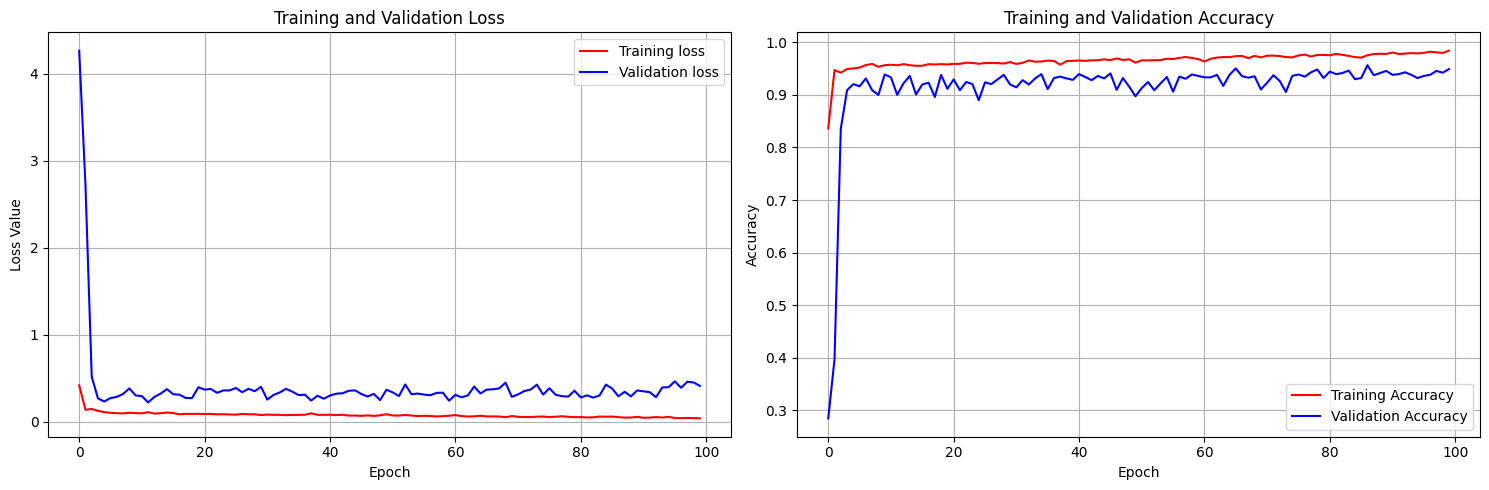

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

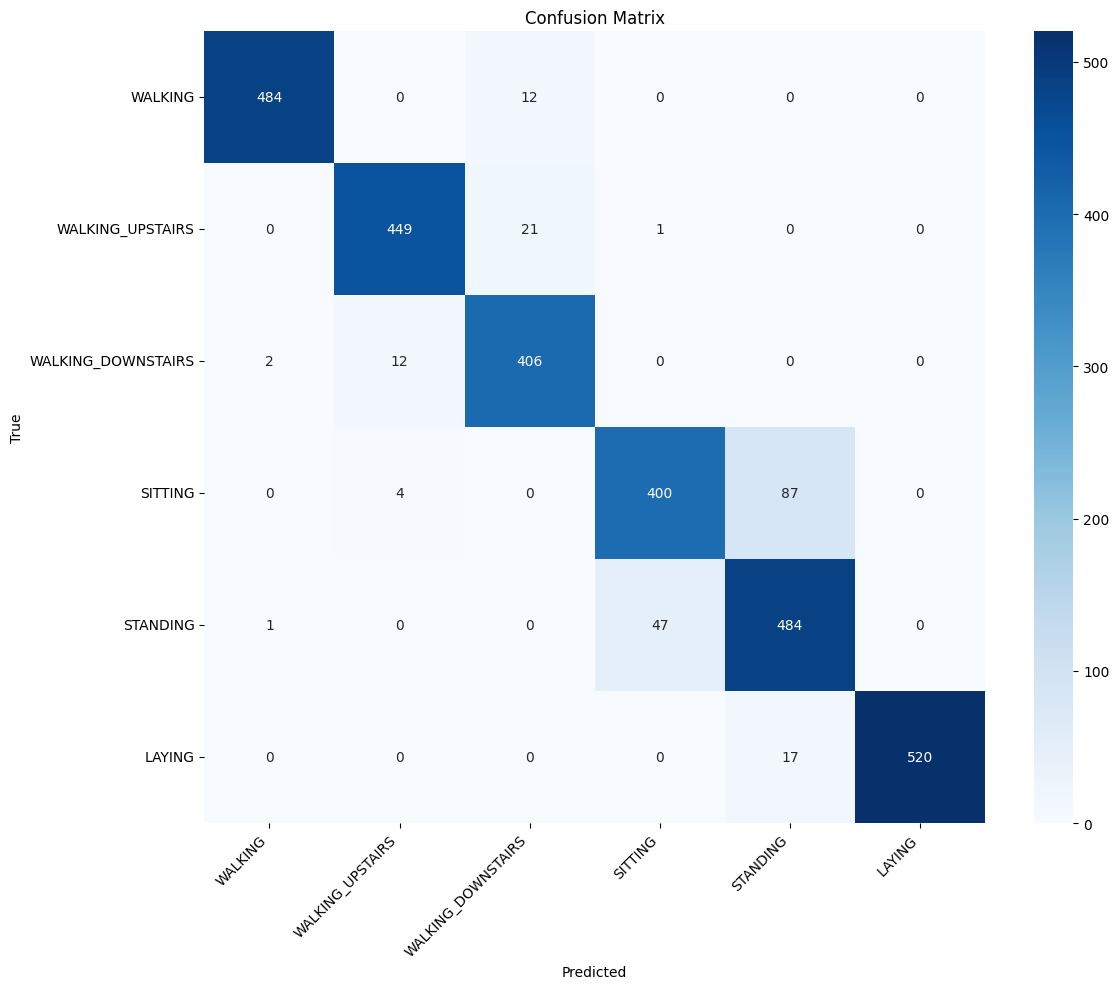

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 3
- CNN 2, GRU 1

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GRU(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,774 (565.52 KB)

 Trainable params: 144,390 (564.02 KB)

 Non-trainable params: 384 (1.50 KB)

None


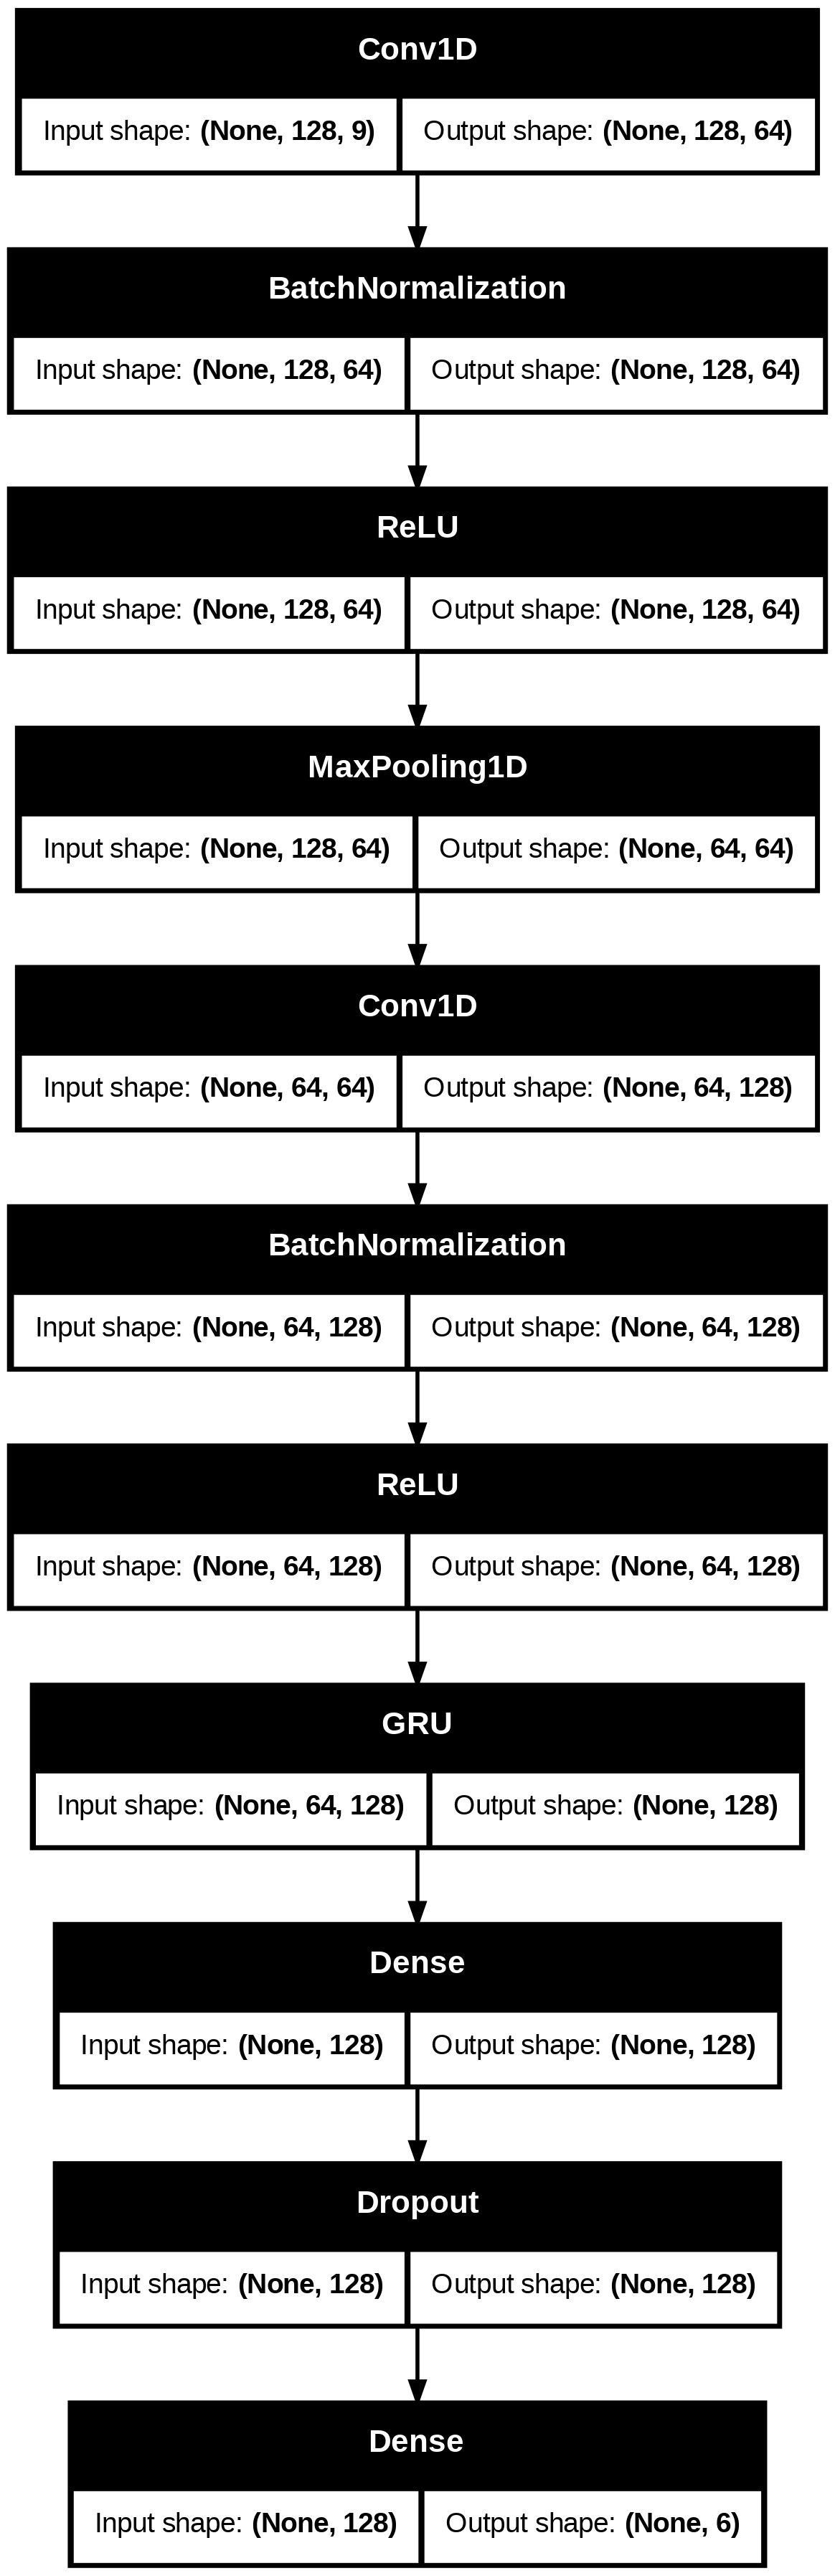

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_best3.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8580 - sparse_categorical_accuracy: 0.6543
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.77776, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.8546 - sparse_categorical_accuracy: 0.6556 - val_loss: 2.4621 - val_sparse_categorical_accuracy: 0.2712
Epoch 2/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1751 - sparse_categorical_accuracy: 0.9276
Epoch 2: sparse_categorical_accuracy improved from 0.77776 to 0.93607, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1748 - sparse_categorical_accuracy: 0.9277 - val_loss: 1.5686 - val_sparse_categorical_accuracy: 0.5642
Epoch 3/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1338 - sparse_categorical_accuracy: 0.9418
Epoch 3: sparse_categorical_accuracy improved from 0.93607 to 0.94525, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1337 - sparse_categorical_accuracy: 0.9419 - val_loss: 0.2920 - val_sparse_categorical_accuracy: 0.8742
Epoch 4/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9527
Epoch 4: sparse_categorical_accuracy improved from 0.94525 to 0.95018, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9526 - val_loss: 0.2094 - val_sparse_categorical_accuracy: 0.9259
Epoch 5/100
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.9543
Epoch 5: sparse_categorical_accuracy improved from 0.95018 to 0.95613, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.2579 - val_sparse_categorical_accuracy: 0.9347
Epoch 6/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1080 - sparse_categorical_accuracy: 0.9527
Epoch 6: sparse_categorical_accuracy improved from 0.95613 to 0.95647, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.2810 - val_sparse_categorical_accuracy: 0.9361
Epoch 7/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1127 - sparse_categorical_accuracy: 0.9527
Epoch 7: sparse_categorical_accuracy did not improve from 0.95647
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1126 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.2651 - val_sparse_categorical_accuracy: 0.9300
Epoch 8/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.9512
Epoch 8: sparse_categorical_accuracy did not improve from 0.95647
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.2706 - val_sparse_categorical_accuracy: 0.9347
Epoch 9/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9566
Epoch 9: sparse_categorical_accuracy did not improve from 0.95647
92/92 ━━━━━━━━━━━━━━━━━━━━ 1

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.2938 - val_sparse_categorical_accuracy: 0.9320
Epoch 12/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9537
Epoch 12: sparse_categorical_accuracy improved from 0.95732 to 0.95766, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0919 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.2554 - val_sparse_categorical_accuracy: 0.9239
Epoch 13/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9483
Epoch 13: sparse_categorical_accuracy did not improve from 0.95766
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1136 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.3036 - val_sparse_categorical_accuracy: 0.9286
Epoch 14/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0862 - sparse_categorical_accuracy: 0.9588
Epoch 14: sparse_categorical_accuracy improved from 0.95766 to 0.96021, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0862 - sparse_categorical_accuracy: 0.9589 - val_loss: 0.2610 - val_sparse_categorical_accuracy: 0.9347
Epoch 15/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0882 - sparse_categorical_accuracy: 0.9576
Epoch 15: sparse_categorical_accuracy did not improve from 0.96021
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0882 - sparse_categorical_accuracy: 0.9576 - val_loss: 0.2998 - val_sparse_categorical_accuracy: 0.9361
Epoch 16/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.9589
Epoch 16: sparse_categorical_accuracy did not improve from 0.96021
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.9589 - val_loss: 0.2949 - val_sparse_categorical_accuracy: 0.9313
Epoch 17/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0863 - sparse_categorical_accuracy: 0.9594
Epoch 17: sparse_categorical_accuracy did not improve from 0.96021
92/92 ━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0751 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.3030 - val_sparse_categorical_accuracy: 0.9334
Epoch 19/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9619
Epoch 19: sparse_categorical_accuracy improved from 0.96038 to 0.96140, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0833 - sparse_categorical_accuracy: 0.9619 - val_loss: 0.3414 - val_sparse_categorical_accuracy: 0.9313
Epoch 20/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9654
Epoch 20: sparse_categorical_accuracy improved from 0.96140 to 0.96225, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0762 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.3341 - val_sparse_categorical_accuracy: 0.9184
Epoch 21/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0763 - sparse_categorical_accuracy: 0.9637
Epoch 21: sparse_categorical_accuracy improved from 0.96225 to 0.96242, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0763 - sparse_categorical_accuracy: 0.9636 - val_loss: 0.3826 - val_sparse_categorical_accuracy: 0.9341
Epoch 22/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9637
Epoch 22: sparse_categorical_accuracy improved from 0.96242 to 0.96276, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0841 - sparse_categorical_accuracy: 0.9637 - val_loss: 0.3532 - val_sparse_categorical_accuracy: 0.9375
Epoch 23/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9679
Epoch 23: sparse_categorical_accuracy did not improve from 0.96276
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0734 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.3334 - val_sparse_categorical_accuracy: 0.9184
Epoch 24/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9590
Epoch 24: sparse_categorical_accuracy did not improve from 0.96276
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9591 - val_loss: 0.3163 - val_sparse_categorical_accuracy: 0.9184
Epoch 25/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0826 - sparse_categorical_accuracy: 0.9578
Epoch 25: sparse_categorical_accuracy did not improve from 0.96276
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.3959 - val_sparse_categorical_accuracy: 0.9354
Epoch 28/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9596
Epoch 28: sparse_categorical_accuracy did not improve from 0.96395
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9597 - val_loss: 0.4632 - val_sparse_categorical_accuracy: 0.9266
Epoch 29/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0983 - sparse_categorical_accuracy: 0.9580
Epoch 29: sparse_categorical_accuracy did not improve from 0.96395
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0979 - sparse_categorical_accuracy: 0.9581 - val_loss: 0.3652 - val_sparse_categorical_accuracy: 0.9388
Epoch 30/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0767 - sparse_categorical_accuracy: 0.9623
Epoch 30: sparse_categorical_accuracy did not improve from 0.96395
92/92 ━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9641 - val_loss: 0.3596 - val_sparse_categorical_accuracy: 0.9232
Epoch 33/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0692 - sparse_categorical_accuracy: 0.9668
Epoch 33: sparse_categorical_accuracy did not improve from 0.96582
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.3260 - val_sparse_categorical_accuracy: 0.9075
Epoch 34/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9695
Epoch 34: sparse_categorical_accuracy did not improve from 0.96582
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.3298 - val_sparse_categorical_accuracy: 0.9361
Epoch 35/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0761 - sparse_categorical_accuracy: 0.9603
Epoch 35: sparse_categorical_accuracy did not improve from 0.96582
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.3295 - val_sparse_categorical_accuracy: 0.9334
Epoch 38/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0814 - sparse_categorical_accuracy: 0.9656
Epoch 38: sparse_categorical_accuracy did not improve from 0.96854
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0812 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.3247 - val_sparse_categorical_accuracy: 0.9307
Epoch 39/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9608
Epoch 39: sparse_categorical_accuracy did not improve from 0.96854
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0756 - sparse_categorical_accuracy: 0.9609 - val_loss: 0.3407 - val_sparse_categorical_accuracy: 0.9266
Epoch 40/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0713 - sparse_categorical_accuracy: 0.9670
Epoch 40: sparse_categorical_accuracy did not improve from 0.96854
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0645 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.3584 - val_sparse_categorical_accuracy: 0.9259
Epoch 46/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9743
Epoch 46: sparse_categorical_accuracy improved from 0.96939 to 0.96973, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.9286
Epoch 47/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0646 - sparse_categorical_accuracy: 0.9651
Epoch 47: sparse_categorical_accuracy did not improve from 0.96973
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.3730 - val_sparse_categorical_accuracy: 0.9116
Epoch 48/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0607 - sparse_categorical_accuracy: 0.9729
Epoch 48: sparse_categorical_accuracy did not improve from 0.96973
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0607 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.3847 - val_sparse_categorical_accuracy: 0.9164
Epoch 49/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9710
Epoch 49: sparse_categorical_accuracy improved from 0.96973 to 0.97024, saving model to 

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9710 - val_loss: 0.3512 - val_sparse_categorical_accuracy: 0.9103
Epoch 50/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9685
Epoch 50: sparse_categorical_accuracy did not improve from 0.97024
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.3855 - val_sparse_categorical_accuracy: 0.9069
Epoch 51/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0635 - sparse_categorical_accuracy: 0.9660
Epoch 51: sparse_categorical_accuracy did not improve from 0.97024
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0637 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.4246 - val_sparse_categorical_accuracy: 0.9293
Epoch 52/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0677 - sparse_categorical_accuracy: 0.9646
Epoch 52: sparse_categorical_accuracy did not improve from 0.97024
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.3482 - val_sparse_categorical_accuracy: 0.9341
Epoch 54/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9683
Epoch 54: sparse_categorical_accuracy improved from 0.97109 to 0.97194, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0667 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.3585 - val_sparse_categorical_accuracy: 0.9381
Epoch 55/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0700 - sparse_categorical_accuracy: 0.9686
Epoch 55: sparse_categorical_accuracy did not improve from 0.97194
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0700 - sparse_categorical_accuracy: 0.9687 - val_loss: 0.3161 - val_sparse_categorical_accuracy: 0.9232
Epoch 56/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9673
Epoch 56: sparse_categorical_accuracy did not improve from 0.97194
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0692 - sparse_categorical_accuracy: 0.9674 - val_loss: 0.3886 - val_sparse_categorical_accuracy: 0.9239
Epoch 57/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0594 - sparse_categorical_accuracy: 0.9694
Epoch 57: sparse_categorical_accuracy did not improve from 0.97194
92/92 ━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9738 - val_loss: 0.4270 - val_sparse_categorical_accuracy: 0.9320
Epoch 59/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0603 - sparse_categorical_accuracy: 0.9685
Epoch 59: sparse_categorical_accuracy did not improve from 0.97517
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0605 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.3766 - val_sparse_categorical_accuracy: 0.9313
Epoch 60/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9659
Epoch 60: sparse_categorical_accuracy did not improve from 0.97517
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0630 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.4405 - val_sparse_categorical_accuracy: 0.9347
Epoch 61/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9641
Epoch 61: sparse_categorical_accuracy did not improve from 0.97517
92/92 ━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0484 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.4223 - val_sparse_categorical_accuracy: 0.9239
Epoch 72/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9760
Epoch 72: sparse_categorical_accuracy did not improve from 0.97721
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.4274 - val_sparse_categorical_accuracy: 0.9381
Epoch 73/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9752
Epoch 73: sparse_categorical_accuracy did not improve from 0.97721
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.3664 - val_sparse_categorical_accuracy: 0.9361
Epoch 74/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0492 - sparse_categorical_accuracy: 0.9785
Epoch 74: sparse_categorical_accuracy improved from 0.97721 to 0.97789, saving model to U

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0492 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.4445 - val_sparse_categorical_accuracy: 0.9347
Epoch 75/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0556 - sparse_categorical_accuracy: 0.9776
Epoch 75: sparse_categorical_accuracy did not improve from 0.97789
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0556 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.4692 - val_sparse_categorical_accuracy: 0.9354
Epoch 76/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9764
Epoch 76: sparse_categorical_accuracy did not improve from 0.97789
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.3560 - val_sparse_categorical_accuracy: 0.9327
Epoch 77/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9793
Epoch 77: sparse_categorical_accuracy improved from 0.97789 to 0.97994, saving model to U

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.5101 - val_sparse_categorical_accuracy: 0.9313
Epoch 78/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9737
Epoch 78: sparse_categorical_accuracy did not improve from 0.97994
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9738 - val_loss: 0.4161 - val_sparse_categorical_accuracy: 0.9368
Epoch 79/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9816
Epoch 79: sparse_categorical_accuracy did not improve from 0.97994
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.4347 - val_sparse_categorical_accuracy: 0.9388
Epoch 80/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9805
Epoch 80: sparse_categorical_accuracy did not improve from 0.97994
92/92 ━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.4310 - val_sparse_categorical_accuracy: 0.9402
Epoch 84/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0452 - sparse_categorical_accuracy: 0.9807
Epoch 84: sparse_categorical_accuracy did not improve from 0.98130
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.4852 - val_sparse_categorical_accuracy: 0.9341
Epoch 85/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9827
Epoch 85: sparse_categorical_accuracy improved from 0.98130 to 0.98181, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.3812 - val_sparse_categorical_accuracy: 0.9402
Epoch 86/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0397 - sparse_categorical_accuracy: 0.9829
Epoch 86: sparse_categorical_accuracy improved from 0.98181 to 0.98249, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0397 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.4102 - val_sparse_categorical_accuracy: 0.9409
Epoch 87/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9855
Epoch 87: sparse_categorical_accuracy improved from 0.98249 to 0.98470, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.4279 - val_sparse_categorical_accuracy: 0.9470
Epoch 88/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9813
Epoch 88: sparse_categorical_accuracy did not improve from 0.98470
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.4427 - val_sparse_categorical_accuracy: 0.9313
Epoch 89/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9801
Epoch 89: sparse_categorical_accuracy did not improve from 0.98470
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.4408 - val_sparse_categorical_accuracy: 0.9218
Epoch 90/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0416 - sparse_categorical_accuracy: 0.9829
Epoch 90: sparse_categorical_accuracy did not improve from 0.98470
92/92 ━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.4236 - val_sparse_categorical_accuracy: 0.9497
Epoch 96/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0367 - sparse_categorical_accuracy: 0.9837
Epoch 96: sparse_categorical_accuracy did not improve from 0.98538
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.4661 - val_sparse_categorical_accuracy: 0.9415
Epoch 97/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9859
Epoch 97: sparse_categorical_accuracy did not improve from 0.98538
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.3532 - val_sparse_categorical_accuracy: 0.9463
Epoch 98/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0311 - sparse_categorical_accuracy: 0.9842
Epoch 98: sparse_categorical_accuracy did not improve from 0.98538
92/92 ━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.3980 - val_sparse_categorical_accuracy: 0.9504
Epoch 100/100
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0353 - sparse_categorical_accuracy: 0.9845
Epoch 100: sparse_categorical_accuracy improved from 0.98555 to 0.98691, saving model to UCI_HAR_CNN_GRU_best3.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0351 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.4613 - val_sparse_categorical_accuracy: 0.9415
Restoring model weights from the end of the best epoch: 100.


In [ ]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_CNN_GRU_best3.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 97.67%
Training loss: 0.1261
Test accuracy: 92.91%
Test loss: 0.4993


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9234    0.9602       496
           1     0.9839    0.9108    0.9460       471
           2     0.8727    0.9952    0.9299       420
           3     0.8571    0.8554    0.8563       491
           4     0.8702    0.8947    0.8823       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.9291      2947
   macro avg     0.9307    0.9299    0.9291      2947
weighted avg     0.9321    0.9291    0.9295      2947



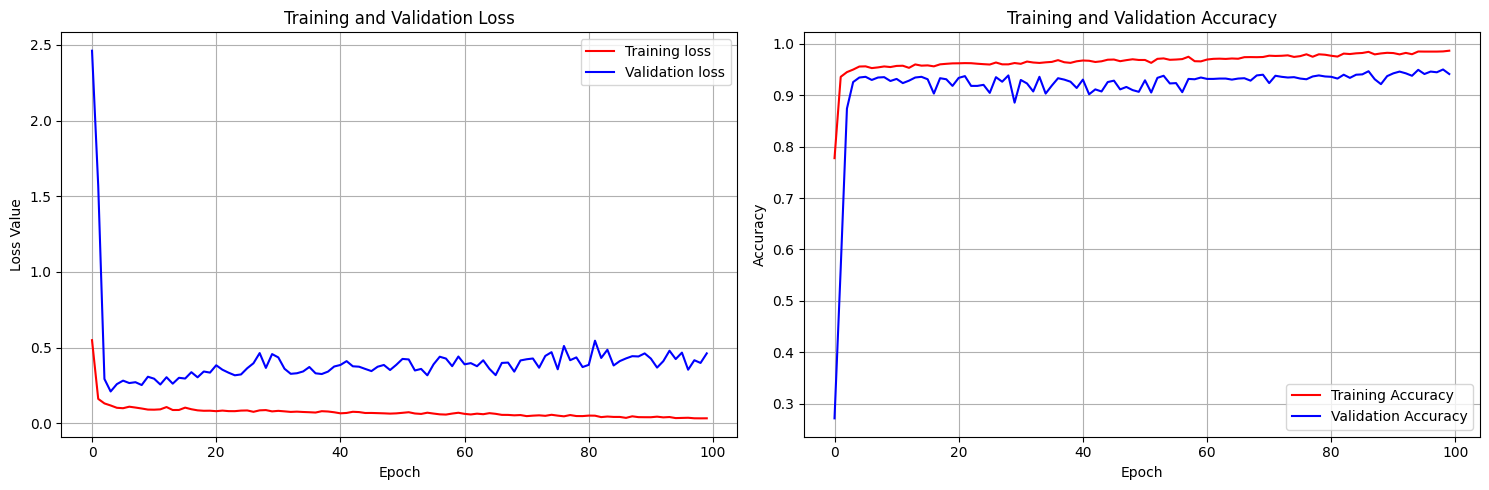

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

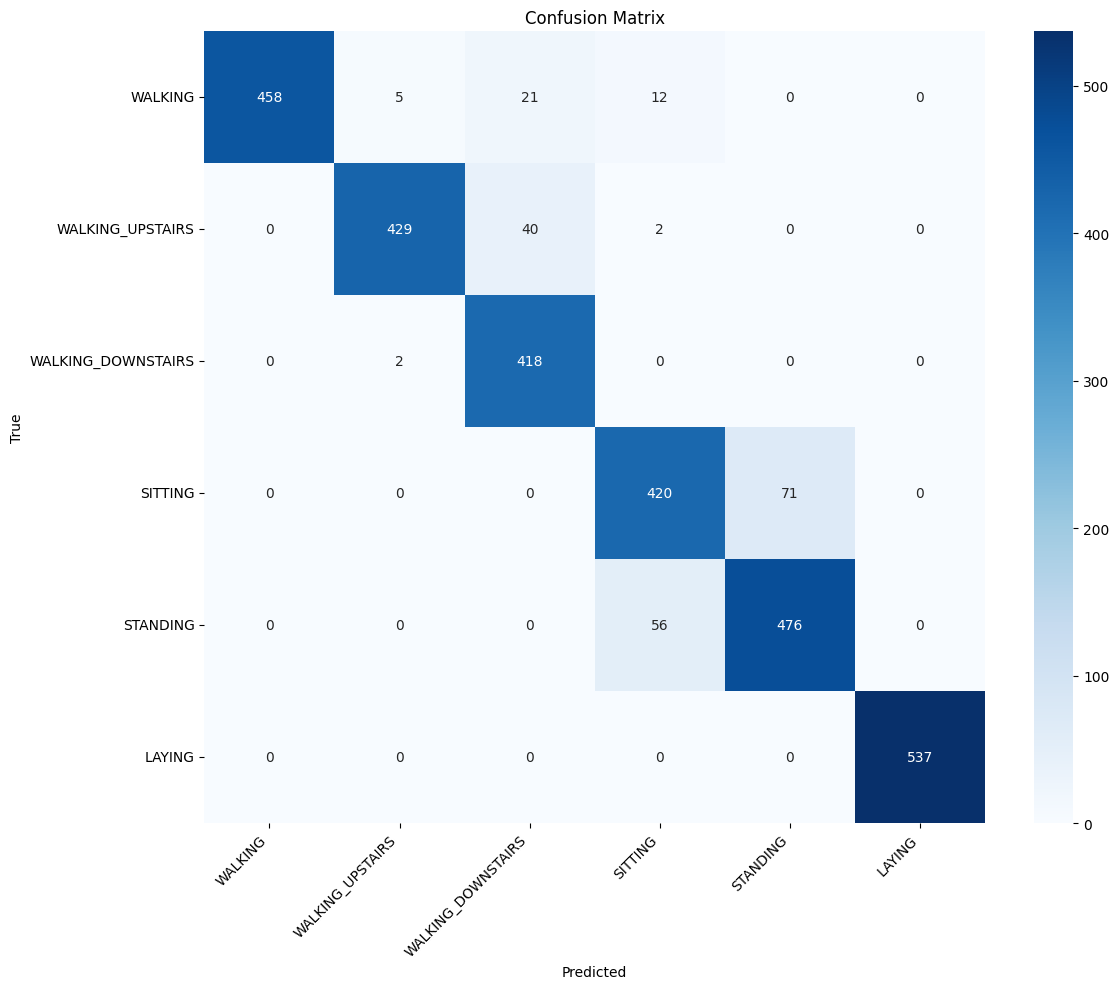

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 4
- CNN 2, GRU 2

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GRU(128, return_sequences=True, dropout=0.2),
    GRU(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 64, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,846 (952.52 KB)

 Trainable params: 243,462 (951.02 KB)

 Non-trainable params: 384 (1.50 KB)

None


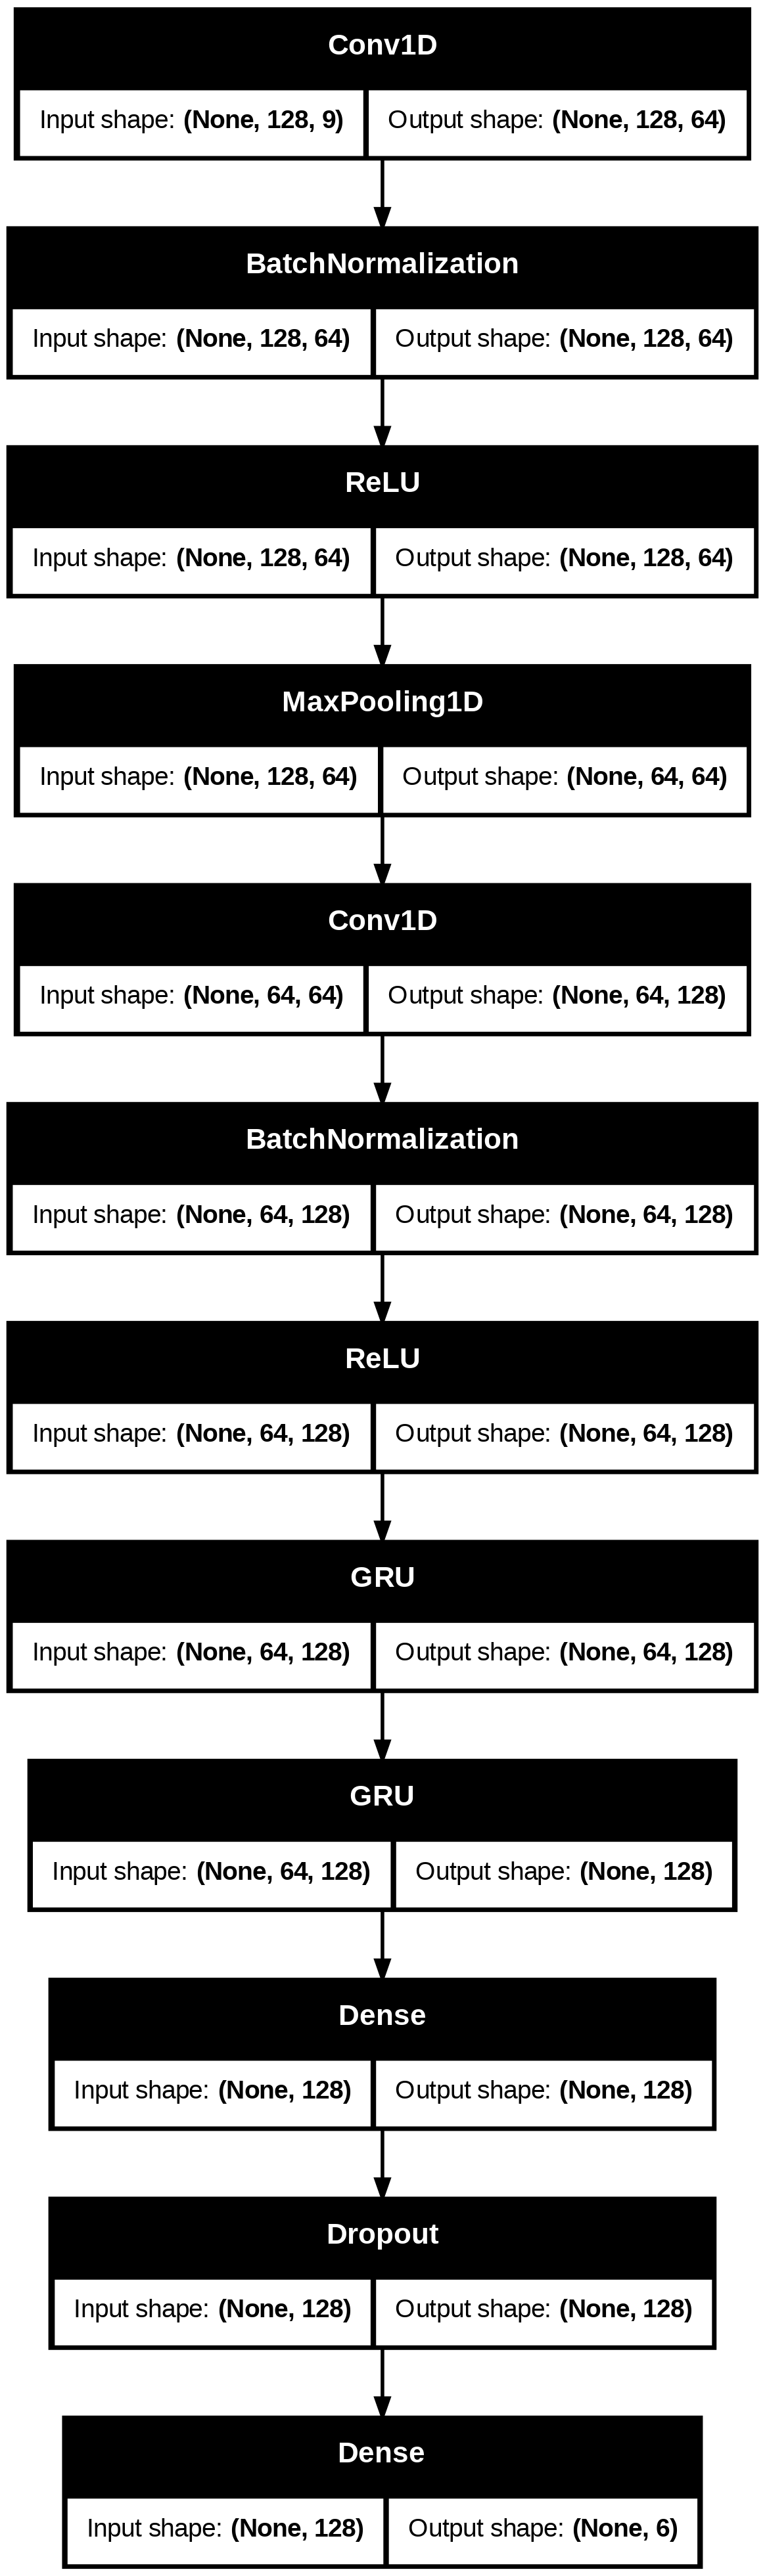

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_best4.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1012 - sparse_categorical_accuracy: 0.9544
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.95562, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.2675 - val_sparse_categorical_accuracy: 0.9361
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0917 - sparse_categorical_accuracy: 0.9595
Epoch 2: sparse_categorical_accuracy did not improve from 0.95562
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.2249 - val_sparse_categorical_accuracy: 0.8994
Epoch 3/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9521
Epoch 3: sparse_categorical_accuracy improved from 0.95562 to 0.95800, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1000 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.3393 - val_sparse_categorical_accuracy: 0.9150
Epoch 4/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0878 - sparse_categorical_accuracy: 0.9571
Epoch 4: sparse_categorical_accuracy did not improve from 0.95800
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0880 - sparse_categorical_accuracy: 0.9571 - val_loss: 0.3601 - val_sparse_categorical_accuracy: 0.9245
Epoch 5/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9585
Epoch 5: sparse_categorical_accuracy improved from 0.95800 to 0.96089, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9586 - val_loss: 0.3989 - val_sparse_categorical_accuracy: 0.9205
Epoch 6/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.9598
Epoch 6: sparse_categorical_accuracy did not improve from 0.96089
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9598 - val_loss: 0.3310 - val_sparse_categorical_accuracy: 0.9361
Epoch 7/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9595
Epoch 7: sparse_categorical_accuracy did not improve from 0.96089
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0876 - sparse_categorical_accuracy: 0.9595 - val_loss: 0.2833 - val_sparse_categorical_accuracy: 0.9273
Epoch 8/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0895 - sparse_categorical_accuracy: 0.9574
Epoch 8: sparse_categorical_accuracy did not improve from 0.96089
92/92 ━━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.3796 - val_sparse_categorical_accuracy: 0.9109
Epoch 12/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0832 - sparse_categorical_accuracy: 0.9626
Epoch 12: sparse_categorical_accuracy did not improve from 0.96106
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0836 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.3713 - val_sparse_categorical_accuracy: 0.9375
Epoch 13/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0917 - sparse_categorical_accuracy: 0.9565
Epoch 13: sparse_categorical_accuracy did not improve from 0.96106
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0916 - sparse_categorical_accuracy: 0.9566 - val_loss: 0.3574 - val_sparse_categorical_accuracy: 0.9198
Epoch 14/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.9512
Epoch 14: sparse_categorical_accuracy did not improve from 0.96106
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0895 - sparse_categorical_accuracy: 0.9595 - val_loss: 0.3057 - val_sparse_categorical_accuracy: 0.9048
Epoch 18/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0734 - sparse_categorical_accuracy: 0.9634
Epoch 18: sparse_categorical_accuracy improved from 0.96123 to 0.96174, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.3409 - val_sparse_categorical_accuracy: 0.9130
Epoch 19/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0850 - sparse_categorical_accuracy: 0.9577
Epoch 19: sparse_categorical_accuracy did not improve from 0.96174
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0849 - sparse_categorical_accuracy: 0.9578 - val_loss: 0.3527 - val_sparse_categorical_accuracy: 0.9007
Epoch 20/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0899 - sparse_categorical_accuracy: 0.9622
Epoch 20: sparse_categorical_accuracy did not improve from 0.96174
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.2642 - val_sparse_categorical_accuracy: 0.9205
Epoch 21/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9601
Epoch 21: sparse_categorical_accuracy did not improve from 0.96174
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.3380 - val_sparse_categorical_accuracy: 0.9035
Epoch 23/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9651
Epoch 23: sparse_categorical_accuracy improved from 0.96208 to 0.96514, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0767 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.2769 - val_sparse_categorical_accuracy: 0.9225
Epoch 24/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0762 - sparse_categorical_accuracy: 0.9651
Epoch 24: sparse_categorical_accuracy improved from 0.96514 to 0.96565, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0762 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.2760 - val_sparse_categorical_accuracy: 0.9198
Epoch 25/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9640
Epoch 25: sparse_categorical_accuracy did not improve from 0.96565
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0851 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.9354
Epoch 26/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0663 - sparse_categorical_accuracy: 0.9672
Epoch 26: sparse_categorical_accuracy did not improve from 0.96565
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0664 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.3022 - val_sparse_categorical_accuracy: 0.9218
Epoch 27/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9623
Epoch 27: sparse_categorical_accuracy did not improve from 0.96565
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0719 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.2549 - val_sparse_categorical_accuracy: 0.9198
Epoch 30/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0719 - sparse_categorical_accuracy: 0.9658
Epoch 30: sparse_categorical_accuracy did not improve from 0.96599
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0719 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.3798 - val_sparse_categorical_accuracy: 0.9082
Epoch 31/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9628
Epoch 31: sparse_categorical_accuracy did not improve from 0.96599
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0767 - sparse_categorical_accuracy: 0.9628 - val_loss: 0.3079 - val_sparse_categorical_accuracy: 0.9286
Epoch 32/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0.9580
Epoch 32: sparse_categorical_accuracy did not improve from 0.96599
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0646 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.3886 - val_sparse_categorical_accuracy: 0.9327
Epoch 40/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9679
Epoch 40: sparse_categorical_accuracy did not improve from 0.96786
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.3238 - val_sparse_categorical_accuracy: 0.9320
Epoch 41/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0632 - sparse_categorical_accuracy: 0.9692
Epoch 41: sparse_categorical_accuracy did not improve from 0.96786
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0633 - sparse_categorical_accuracy: 0.9692 - val_loss: 0.2581 - val_sparse_categorical_accuracy: 0.9368
Epoch 42/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0659 - sparse_categorical_accuracy: 0.9695
Epoch 42: sparse_categorical_accuracy improved from 0.96786 to 0.97007, saving model t

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0660 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.2914 - val_sparse_categorical_accuracy: 0.9286
Epoch 43/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.9679
Epoch 43: sparse_categorical_accuracy did not improve from 0.97007
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.9678 - val_loss: 0.3082 - val_sparse_categorical_accuracy: 0.9273
Epoch 44/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9635
Epoch 44: sparse_categorical_accuracy did not improve from 0.97007
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0772 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.3246 - val_sparse_categorical_accuracy: 0.8776
Epoch 45/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1110 - sparse_categorical_accuracy: 0.9558
Epoch 45: sparse_categorical_accuracy did not improve from 0.97007
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0604 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.3320 - val_sparse_categorical_accuracy: 0.9191
Epoch 50/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9720
Epoch 50: sparse_categorical_accuracy improved from 0.97160 to 0.97177, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.3001 - val_sparse_categorical_accuracy: 0.9381
Epoch 51/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9686
Epoch 51: sparse_categorical_accuracy did not improve from 0.97177
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9686 - val_loss: 0.2431 - val_sparse_categorical_accuracy: 0.9225
Epoch 52/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0802 - sparse_categorical_accuracy: 0.9659
Epoch 52: sparse_categorical_accuracy did not improve from 0.97177
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0801 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.2886 - val_sparse_categorical_accuracy: 0.9341
Epoch 53/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9728
Epoch 53: sparse_categorical_accuracy did not improve from 0.97177
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0645 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.3237 - val_sparse_categorical_accuracy: 0.9320
Epoch 60/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0584 - sparse_categorical_accuracy: 0.9751
Epoch 60: sparse_categorical_accuracy did not improve from 0.97211
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0585 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.3883 - val_sparse_categorical_accuracy: 0.9334
Epoch 61/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9688
Epoch 61: sparse_categorical_accuracy did not improve from 0.97211
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0570 - sparse_categorical_accuracy: 0.9689 - val_loss: 0.3243 - val_sparse_categorical_accuracy: 0.9409
Epoch 62/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9774
Epoch 62: sparse_categorical_accuracy improved from 0.97211 to 0.97517, saving model t

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0517 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.3039 - val_sparse_categorical_accuracy: 0.9347
Epoch 63/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0668 - sparse_categorical_accuracy: 0.9671
Epoch 63: sparse_categorical_accuracy did not improve from 0.97517
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0664 - sparse_categorical_accuracy: 0.9673 - val_loss: 0.3147 - val_sparse_categorical_accuracy: 0.9388
Epoch 64/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0604 - sparse_categorical_accuracy: 0.9713
Epoch 64: sparse_categorical_accuracy improved from 0.97517 to 0.97534, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.3341 - val_sparse_categorical_accuracy: 0.9368
Epoch 65/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9683
Epoch 65: sparse_categorical_accuracy did not improve from 0.97534
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.2306 - val_sparse_categorical_accuracy: 0.9449
Epoch 66/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9718
Epoch 66: sparse_categorical_accuracy did not improve from 0.97534
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.3477 - val_sparse_categorical_accuracy: 0.9239
Epoch 67/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9731
Epoch 67: sparse_categorical_accuracy did not improve from 0.97534
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.3622 - val_sparse_categorical_accuracy: 0.9259
Epoch 70/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0697 - sparse_categorical_accuracy: 0.9702
Epoch 70: sparse_categorical_accuracy did not improve from 0.97551
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0692 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.2979 - val_sparse_categorical_accuracy: 0.9429
Epoch 71/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0506 - sparse_categorical_accuracy: 0.9781
Epoch 71: sparse_categorical_accuracy improved from 0.97551 to 0.97858, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0506 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.2990 - val_sparse_categorical_accuracy: 0.9375
Epoch 72/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0464 - sparse_categorical_accuracy: 0.9800
Epoch 72: sparse_categorical_accuracy did not improve from 0.97858
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0465 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.2874 - val_sparse_categorical_accuracy: 0.9463
Epoch 73/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9814
Epoch 73: sparse_categorical_accuracy improved from 0.97858 to 0.97926, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9814 - val_loss: 0.3528 - val_sparse_categorical_accuracy: 0.9293
Epoch 74/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0510 - sparse_categorical_accuracy: 0.9763
Epoch 74: sparse_categorical_accuracy did not improve from 0.97926
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.9354
Epoch 75/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9764
Epoch 75: sparse_categorical_accuracy did not improve from 0.97926
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0541 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.2959 - val_sparse_categorical_accuracy: 0.9531
Epoch 76/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0483 - sparse_categorical_accuracy: 0.9809
Epoch 76: sparse_categorical_accuracy did not improve from 0.97926
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.2869 - val_sparse_categorical_accuracy: 0.9477
Epoch 78/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0506 - sparse_categorical_accuracy: 0.9775
Epoch 78: sparse_categorical_accuracy did not improve from 0.97977
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.2846 - val_sparse_categorical_accuracy: 0.9545
Epoch 79/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0460 - sparse_categorical_accuracy: 0.9792
Epoch 79: sparse_categorical_accuracy did not improve from 0.97977
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0463 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.3254 - val_sparse_categorical_accuracy: 0.9531
Epoch 80/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0496 - sparse_categorical_accuracy: 0.9780
Epoch 80: sparse_categorical_accuracy did not improve from 0.97977
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.3291 - val_sparse_categorical_accuracy: 0.9436
Epoch 82/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0457 - sparse_categorical_accuracy: 0.9812
Epoch 82: sparse_categorical_accuracy did not improve from 0.98266
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0459 - sparse_categorical_accuracy: 0.9813 - val_loss: 0.2393 - val_sparse_categorical_accuracy: 0.9293
Epoch 83/100
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9838
Epoch 83: sparse_categorical_accuracy did not improve from 0.98266
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.2671 - val_sparse_categorical_accuracy: 0.9497
Epoch 84/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0452 - sparse_categorical_accuracy: 0.9806
Epoch 84: sparse_categorical_accuracy did not improve from 0.98266
92/92 ━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.3626 - val_sparse_categorical_accuracy: 0.9497
Epoch 87/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9859
Epoch 87: sparse_categorical_accuracy improved from 0.98300 to 0.98623, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.2961 - val_sparse_categorical_accuracy: 0.9497
Epoch 88/100
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0329 - sparse_categorical_accuracy: 0.9887
Epoch 88: sparse_categorical_accuracy improved from 0.98623 to 0.98844, saving model to UCI_HAR_CNN_GRU_best4.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0329 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.3004 - val_sparse_categorical_accuracy: 0.9572
Epoch 89/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0394 - sparse_categorical_accuracy: 0.9837
Epoch 89: sparse_categorical_accuracy did not improve from 0.98844
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0394 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.2970 - val_sparse_categorical_accuracy: 0.9613
Epoch 90/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0423 - sparse_categorical_accuracy: 0.9834
Epoch 90: sparse_categorical_accuracy did not improve from 0.98844
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0423 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.3459 - val_sparse_categorical_accuracy: 0.9511
Epoch 91/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0333 - sparse_categorical_accuracy: 0.9872
Epoch 91: sparse_categorical_accuracy did not improve from 0.98844
92/92 ━━━━━━━━━━━━━

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_CNN_GRU_best4.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 98.38%
Training loss: 0.0787
Test accuracy: 94.84%
Test loss: 0.3167


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9979    0.9577    0.9774       496
           1     0.9768    0.9851    0.9810       471
           2     0.9567    1.0000    0.9779       420
           3     0.9359    0.8024    0.8640       491
           4     0.8516    0.9492    0.8978       532
           5     0.9890    1.0000    0.9944       537

    accuracy                         0.9484      2947
   macro avg     0.9513    0.9491    0.9487      2947
weighted avg     0.9503    0.9484    0.9479      2947



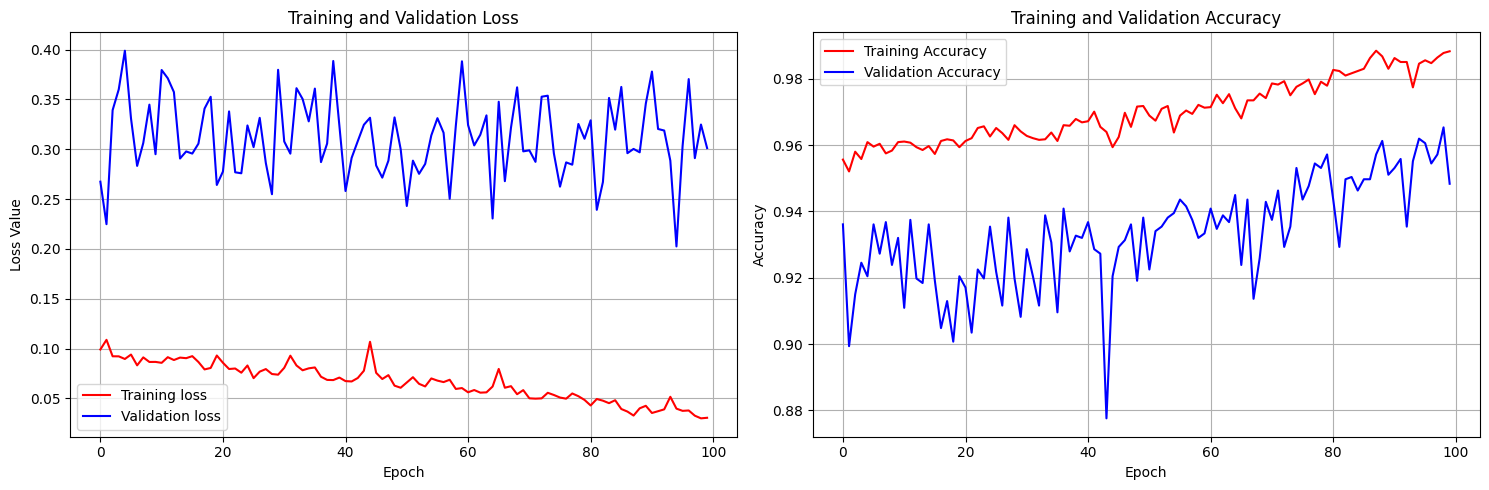

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

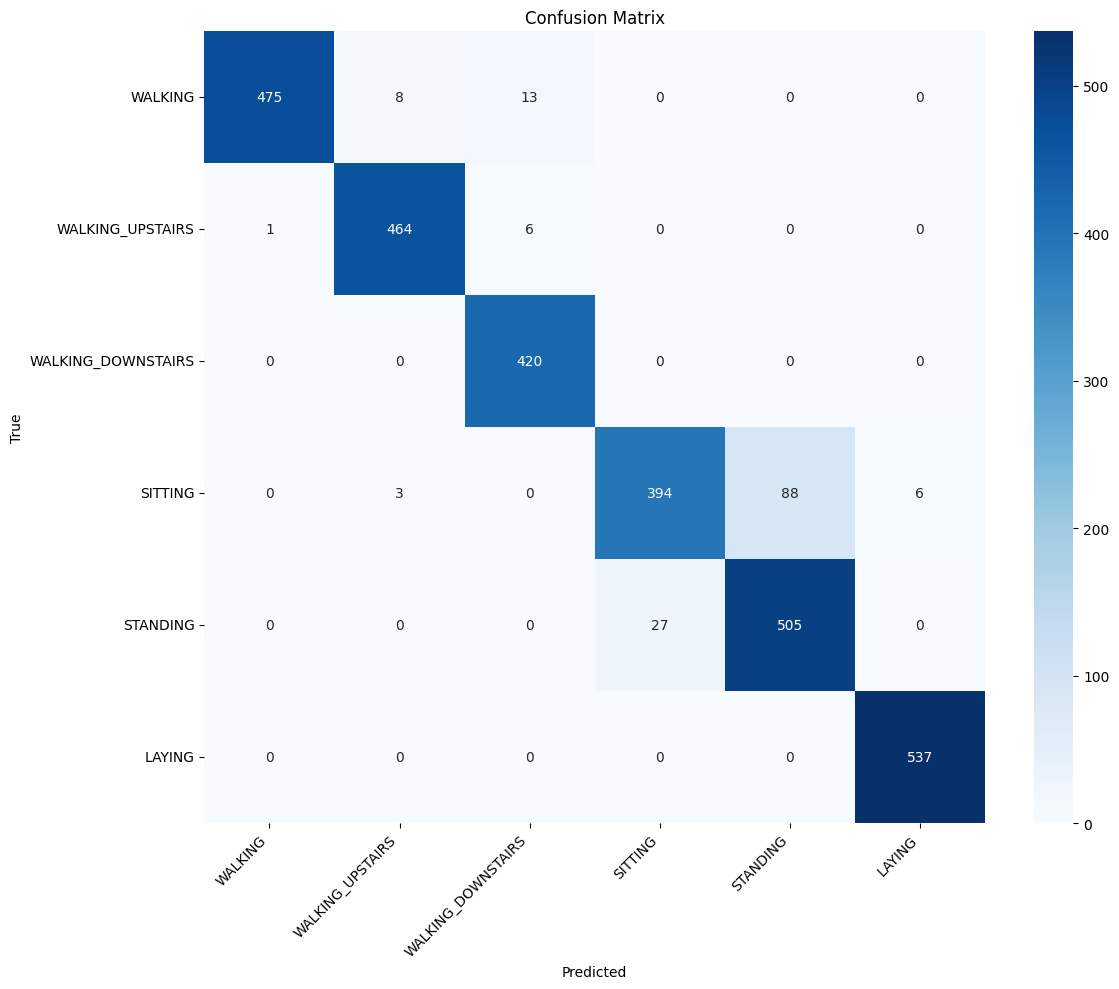

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()